# Dimensionality reduction through Principal Component Analysis

Principal component analysis can be stated as a dimensionality reduction task -- find a hyperplane plane such that the sum of distance squares is minimal. The latter is equivalent to the following data generation model:

* True data $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ lies on a low-dimensional hyperplane.
* Observed data $\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n$ leaks to the higher-dimensional space due to the random pertubations $\boldsymbol{\varepsilon}_1,\ldots,\boldsymbol{\varepsilon}_n$.
* We assume that these pertubations $\boldsymbol{\varepsilon}_1,\ldots,\boldsymbol{\varepsilon}_n$ are independent and come from a sperical normal distribution.

There are two ways this model can be extended:

* We can model perturbations with different sperical distribution such as spherical Laplacian distribution. Such an approach is justified when there are many outliers -- normal distribution has light tails and is thus much more sensitive to extreme outliers than Laplacian distribution.

* We can model the underlying surface differently. For instance, we can assume that the original data comes from a curve or surface. The resulting learning tasks are known as principal curve and principal surface reconstruction. In practice, a multitouch device must solve principal curve problem near realtime to get a good user experinece in drawing.  

We use images and their colorspaces to illustrate basic concepts of dimensionality reduction, as many images have reduced colorspace and the steps done during hyperplane reconstruction are easily interpretable.
Since the colorspace is inherently three dimensional we use package `ipyvolume` for making three dimensional plots interactive. Further details about his package can be obtained from

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)


In [41]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Tools for PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Standard stuff
from pandas import Series
from pandas import DataFrame
from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Image sampling and processing functions

Before we can proceed to colorspace manipulation we need a couple of function to process raw images.
Note that image will be represented as $m\time n\times 3$ `nympy` array `img` where 
* the first channel `img[:,:, 0]` encodes the intensity of reds (R)
* the second channel `img[:,:, 1]` encodes the intensity of greens (G)
* the third channel `img[:,:, 1]` encodes the intensity of blues (B)

Note that there are alternatives to RGB representation such as HSL and HSV with [well-established conversion formulae](https://en.wikipedia.org/wiki/HSL_and_HSV) from which we use some bits and pieces.

### Colorspace formation

In [219]:
def image_to_colorspace(image: np.array, sample_count: int = None) -> DataFrame:
    """
    Reorders the m x n image to (n * n) x 3 matrix where each row corresponds to single pixel.
    
    If sample_count is set then only random subset of rows is returned. 
    """
    
    if sample_count:
        return DataFrame({'R':image[:,:,0].flatten(),'G':image[:,:, 1].flatten(),'B':image[:,:, 2].flatten()}).sample(n = sample_count, replace=False)
    else: 
        return DataFrame({'R':image[:,:,0].flatten(),'G':image[:,:, 1].flatten(),'B':image[:,:, 2].flatten()})

To make our life easier we also need inverse transformation that arranges colorspace back to the image.

In [ ]:
def colorspace_to_image(cspace: DataFrame, m: int, n: int) -> np.array:
    assert len(cspace) == m * n, 'Dimensions must match'
    assert all(tmp.columns.values == ['R', 'G', 'B']), 'Columns must match'
    
    result = np.empty([m,n,3])
    result[:,:, 0] = cspace['R'].values.reshape(m, n)
    result[:,:, 1] = cspace['G'].values.reshape(m, n)
    result[:,:, 2] = cspace['B'].values.reshape(m, n)
    return result

### Luminocity based grayscale conversion

In [6]:
def convert_to_grayscale(image: np.array)-> np.array:
    """Converts RGB image to grayscale image preserving perceived luminocity based on Y_601 formula""" 
    return 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]

## II. Visual inspection of tonality of different paintings

The painings of Pablo Picasso that come from a blue and rose period have exeptional RGB spectrum and thus are good examples for dimensionality reduction.

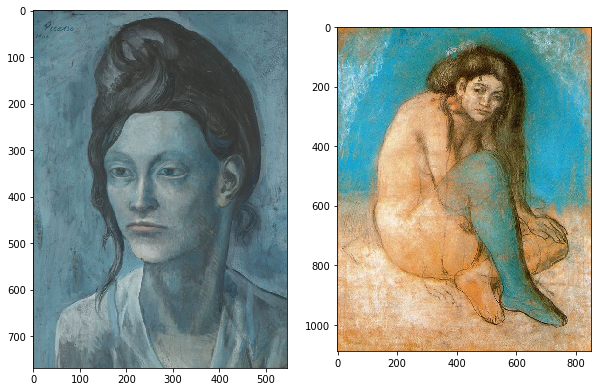

In [7]:
pink_image = plt.imread('data/colorspace/picasso_nude_with_crossed legs_1903.png')
blue_image = plt.imread('data/colorspace/picasso_woman_with_a_helmet_of_hair_1904.png')

fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(blue_image)
fig.add_subplot(1, 2, 2)
plt.imshow(pink_image)

### Colorspace of Woman with a Helmet of Hair

The colorspace of the blue image is almost one-dimensional line. 

In [220]:
fig = ipv.figure()
blue_cs = image_to_colorspace(blue_image, 10000)
scatter = ipv.scatter(blue_cs.loc[:, 'R'].values, blue_cs.loc[:, 'G'].values, blue_cs.loc[:, 'B'].values, color = blue_cs.values, s = 0.5, marker='sphere')
ipv.show()

### Colorspace of Nude with Crossed Legs

The colorspace of the pink image is clearly two-dimansional surface wich is quite flat can can be approximated with hyperplane. 

In [221]:
fig = ipv.figure()
pink_cs = image_to_colorspace(pink_image, 10000)
scatter = ipv.scatter(pink_cs.loc[:, 'R'].values, pink_cs.loc[:, 'G'].values, pink_cs.loc[:, 'B'].values, color = pink_cs.values, s = 0.5, marker='sphere')
ipv.show()

## III. Dimensionality reduction with PCA

### Helper functions

In [140]:
def reduced_0d_colorspace(mu: np.array, k = 30) -> np.array:
    """
    Returns an a k x k image in the mean color
    
    mu   --- mean color 
    k    --- number of colors 
    """
    
    result = np.full([k, k, 3], np.nan)
    for j in range(k):
            result[:, j, :] = mu 
    
    return result

In [141]:
def reduced_1d_colorspace(mu: np.array, pca: np.array, d:float = 0.3, k = 30) -> np.array:
    """
    Returns an image of available colors in reduced one-dimensional colorspace
    
    mu   --- mean color 
    pca  --- principal color 
    d    --- maximal value of xi coefficients
    k    --- number of colors
    """
    
    Xi = np.linspace(-d, d, k)
    result = np.full([k, k, 3], np.nan)
    for j, xi in enumerate(Xi):
            result[:, j, :] = mu + pca * xi
    
    return result

In [142]:
def reduced_2d_colorspace(mu: np.array, pca1: np.array, pca2: np.array, d:float = 0.3, k = 30) -> np.array:
    """
    Returns a k x k image of available colors in reduced two-dimensional colorspace
    
    mu   --- mean color 
    pca1 --- the first principal color 
    pca2 --- the second principal color
    d    --- maximal value of xi coefficients
    k    --- number of colors
    """
    
    Xi1 = np.linspace(-d, d, k)
    Xi2 = np.linspace(-d, d, k)
    result = np.full([k, k, 3], np.nan)
    for i, xi1 in enumerate(Xi1):
        for j, xi2 in enumerate(Xi2):
            result[i, j, :] = mu + pca1 * xi1 + pca2 * xi2
    
    return result

### Woman with a Helmet of Hair

Principal component analysis of the blue picture reveals the following parameters.

In [143]:
pca = PCA()
pca.fit(blue_cs)

W = DataFrame(pca.components_, columns = ['R', 'G', 'B'], index = ['PCA1', 'PCA2', 'PCA3'])
Lambda = DataFrame(pca.explained_variance_, columns=['lambda'], index = ['PCA1', 'PCA2', 'PCA3'])
rel_var = DataFrame(100*pca.explained_variance_ratio_, columns = ['variance'], index = ['PCA1', 'PCA2', 'PCA3'])
mu = DataFrame(pca.mean_, index = ['R', 'G', 'B']).T

mdisplay([Lambda.reset_index(),W.reset_index(), mu, Lambda.reset_index(), rel_var.reset_index(), ], 
         ['Loadings', 'Rotation matrix', 'Mean color', 'Explained absolute variance', 'Explained relative variance'])

Loadings Rotation matrix Mean color Explained absolute variance Explained relative variance 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.040961 
 
 
 PCA2 
 0.001534 
 
 
 PCA3 
 0.000036 
 
 
 
 
 
 index 
 R 
 G 
 B 
 
 
 
 
 PCA1 
 0.474365 
 0.603838 
 0.640592 
 
 
 PCA2 
 0.835082 
 -0.078369 
 -0.544515 
 
 
 PCA3 
 -0.278596 
 0.793245 
 -0.541430 
 
 
 
 
 
 R 
 G 
 B 
 
 
 
 
 0.364542 
 0.453571 
 0.4772 
 
 
 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.040961 
 
 
 PCA2 
 0.001534 
 
 
 PCA3 
 0.000036 
 
 
 
 
 
 index 
 variance 
 
 
 
 
 PCA1 
 96.309129 
 
 
 PCA2 
 3.606288 
 
 
 PCA3 
 0.084583

These parameter have the following interpretations.

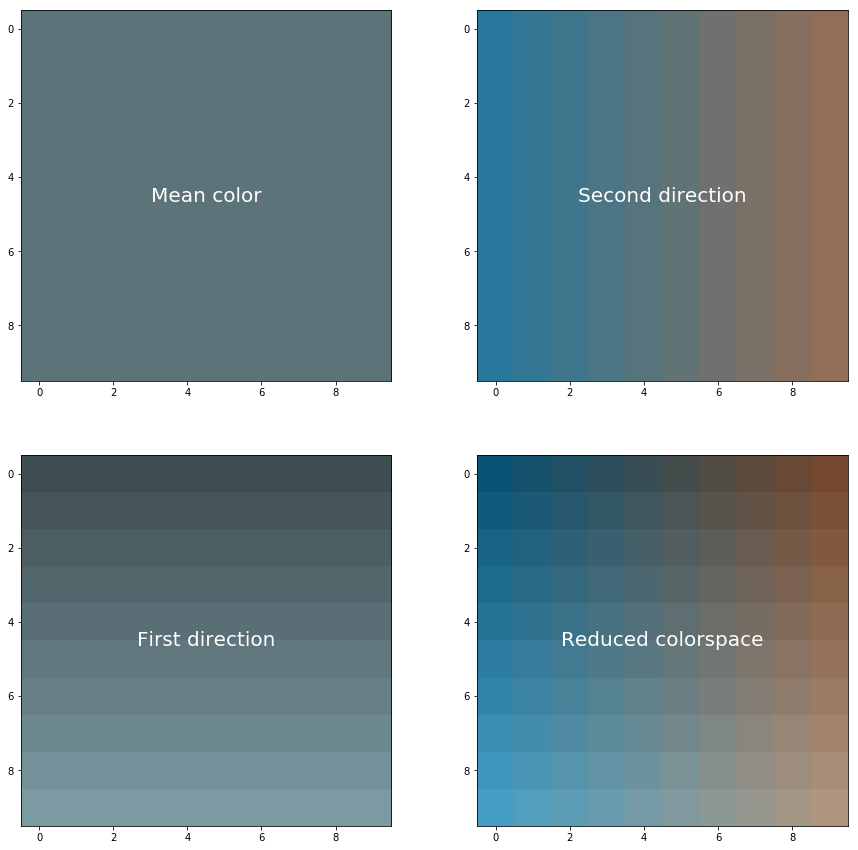

In [165]:
k = 10
d = 0.25
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(reduced_0d_colorspace(mu, k=k))
plt.text((k-1)/2, (k-1)/2, 'Mean color', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(222)
plt.imshow(reduced_1d_colorspace(mu, W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Second direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(223)
plt.imshow(np.transpose(reduced_1d_colorspace(mu, W.loc['PCA1', :], d=d, k=k), axes = [1,0,2]))
plt.text((k-1)/2, (k-1)/2, 'First direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(224)
plt.imshow(reduced_2d_colorspace(mu, W.loc['PCA1', :], W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Reduced colorspace', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
None

### Nude with Crossed Legs

Principal component analysis of the blue picture reveals the following parameters.

In [167]:
pca = PCA()
pca.fit(pink_cs)

W = DataFrame(pca.components_, columns = ['R', 'G', 'B'], index = ['PCA1', 'PCA2', 'PCA3'])
Lambda = DataFrame(pca.explained_variance_, columns=['lambda'], index = ['PCA1', 'PCA2', 'PCA3'])
rel_var = DataFrame(100*pca.explained_variance_ratio_, columns = ['variance'], index = ['PCA1', 'PCA2', 'PCA3'])
mu = DataFrame(pca.mean_, index = ['R', 'G', 'B']).T

mdisplay([Lambda.reset_index(),W.reset_index(), mu, Lambda.reset_index(), rel_var.reset_index(), ], 
         ['Loadings', 'Rotation matrix', 'Mean color', 'Explained absolute variance', 'Explained relative variance'])

Loadings Rotation matrix Mean color Explained absolute variance Explained relative variance 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.090169 
 
 
 PCA2 
 0.046353 
 
 
 PCA3 
 0.000339 
 
 
 
 
 
 index 
 R 
 G 
 B 
 
 
 
 
 PCA1 
 -0.895695 
 -0.396198 
 -0.201884 
 
 
 PCA2 
 -0.374578 
 0.427607 
 0.822705 
 
 
 PCA3 
 0.239628 
 -0.812514 
 0.531412 
 
 
 
 
 
 R 
 G 
 B 
 
 
 
 
 0.572983 
 0.59212 
 0.490528 
 
 
 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.090169 
 
 
 PCA2 
 0.046353 
 
 
 PCA3 
 0.000339 
 
 
 
 
 
 index 
 variance 
 
 
 
 
 PCA1 
 65.883778 
 
 
 PCA2 
 33.868502 
 
 
 PCA3 
 0.247720

These parameter have the following interpretations.

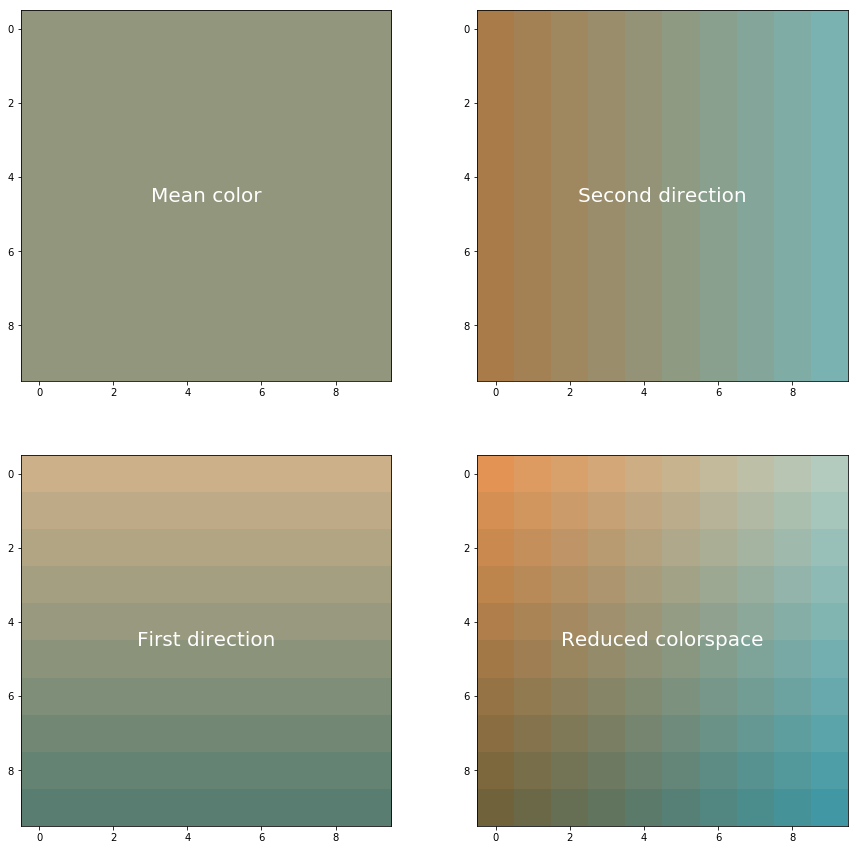

In [168]:
k = 10
d = 0.25
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(reduced_0d_colorspace(mu, k=k))
plt.text((k-1)/2, (k-1)/2, 'Mean color', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(222)
plt.imshow(reduced_1d_colorspace(mu, W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Second direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(223)
plt.imshow(np.transpose(reduced_1d_colorspace(mu, W.loc['PCA1', :], d=d, k=k), axes = [1,0,2]))
plt.text((k-1)/2, (k-1)/2, 'First direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(224)
plt.imshow(reduced_2d_colorspace(mu, W.loc['PCA1', :], W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Reduced colorspace', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
None

### Images reduced to two-dimensional colorspace

By using transform and inverse transform we can reduce the image to more compact colorspace. This makes colors less vibrant but as the third principal component of Woman with a Helmet of Hair explains only $0.08\%$ we should see no difference. 
For Nude with Crossed Legs the change is more pronounced but still negligible as $0.25\%$ of variance is captured by the third component.

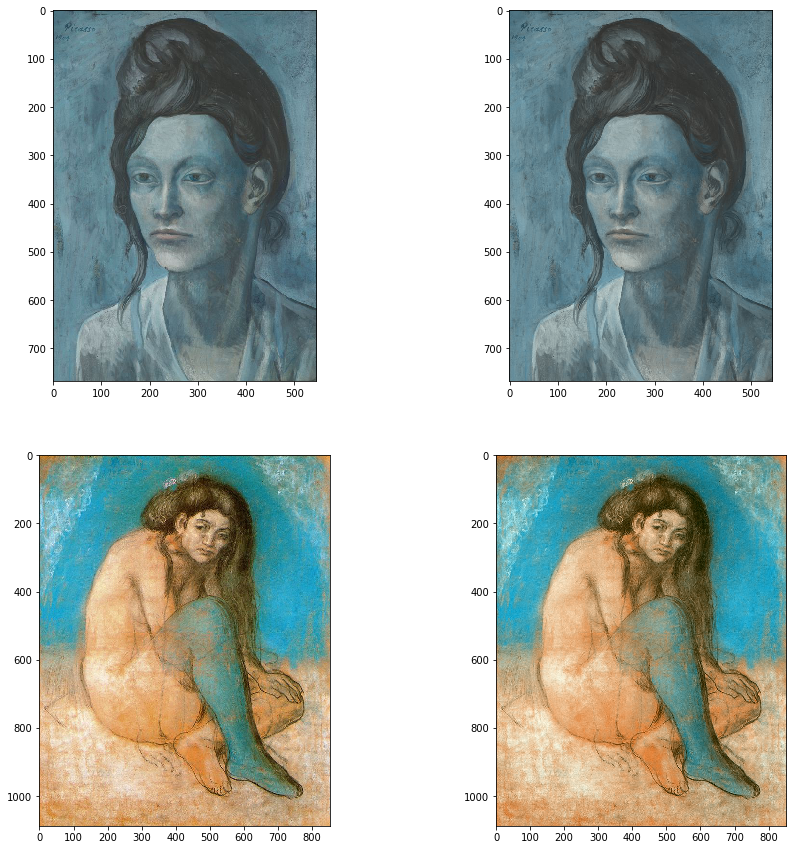

In [251]:
y_blue = image_to_colorspace(blue_image)
m_blue, n_blue, _ = blue_image.shape

pca.fit(blue_cs)
mu_blue = pca.mean_
xi_blue = pca.transform(y_blue)
xi_blue[:, 2] = 0
x_blue = DataFrame(np.clip(pca.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])

y_pink = image_to_colorspace(pink_image)
m_pink, n_pink, _ = pink_image.shape

pca.fit(pink_cs)
mu_pink = pca.mean_
xi_pink = pca.transform(y_pink)
xi_pink[:, 2] = 0
x_pink = DataFrame(np.clip(pca.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(x_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(x_pink, m_pink, n_pink))

### Images reduced to one-dimensional colorspace

We can further reduce the image colorspace to one-dimesional line. This time the change is visible as the second and the  third principal component of Woman with a Helmet of Hair explains $3.68\%$ of the variance. 
For Nude with Crossed Legs the change is even more pronounced as $34.2\%$ of variance is captured by the second and third component.
Nevertheless note that individual details of the paintings are still clearly recognisable and thus must image processing and machine learning algorithms would still provide same results.  

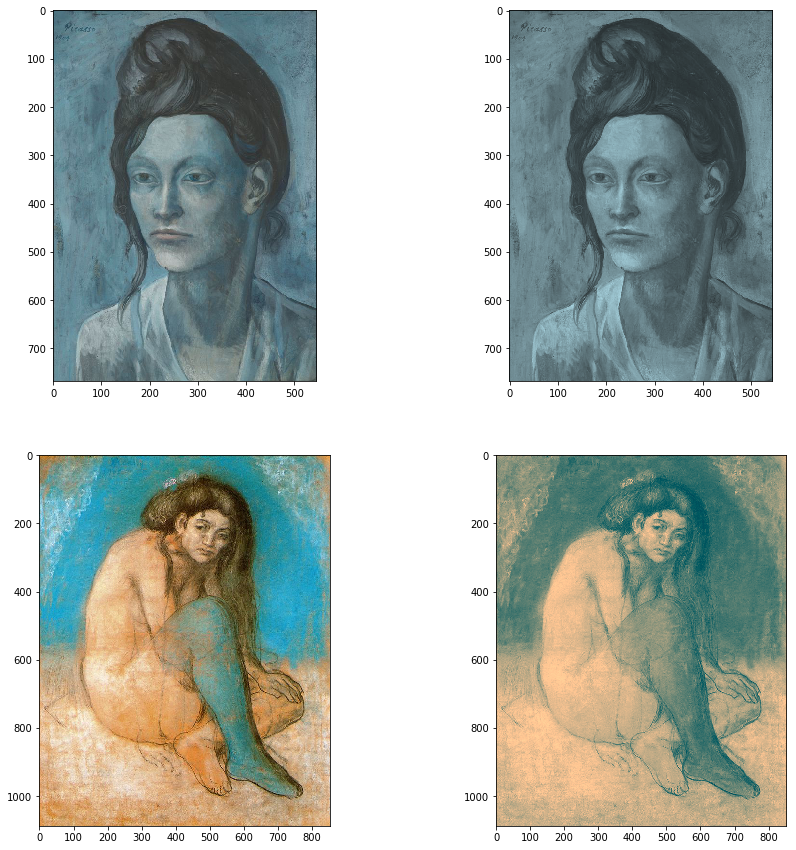

In [255]:
pca.fit(blue_cs)
mu_blue = pca.mean_
xi_blue = pca.transform(y_blue)
xi_blue[:, 2] = 0
xi_blue[:, 1] = 0
x_blue = DataFrame(np.clip(pca.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])

pca.fit(pink_cs)
mu_pink = pca.mean_
xi_pink = pca.transform(y_pink)
xi_pink[:, 2] = 0
xi_pink[:, 1] = 0
x_pink = DataFrame(np.clip(pca.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(x_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(x_pink, m_pink, n_pink))

### Change of tonality through change of principle components

By default PCA does not return scaled $\boldsymbol{\xi}$ coordinates, i.e., their covariance matrix is not identity matrix. However, we can force it by setting `whiten` flag. As a result, the PCA will find a transformation

\begin{align*}
\boldsymbol{\xi} = W (\boldsymbol{y}-\boldsymbol{\mu})  
\end{align*}

such that $\boldsymbol{\xi}$ is a white gaussian noise. Now if we pipe this back to the inverse transformation of another PCA transformation we get a distribution that has the same parameters as the original. To be punctual, this is true only if the second PCA transformation is learned on top of a multivariate normal distribution. Otherwise there are some discrepancises. 

Nevertheless, the resulting cumulative distribution is quite close and thus the tonality is more or less matched. This allows us to convert blue period to rose period and vice versa. Results are not good as we match only colorspace but completely ignore spartial features.

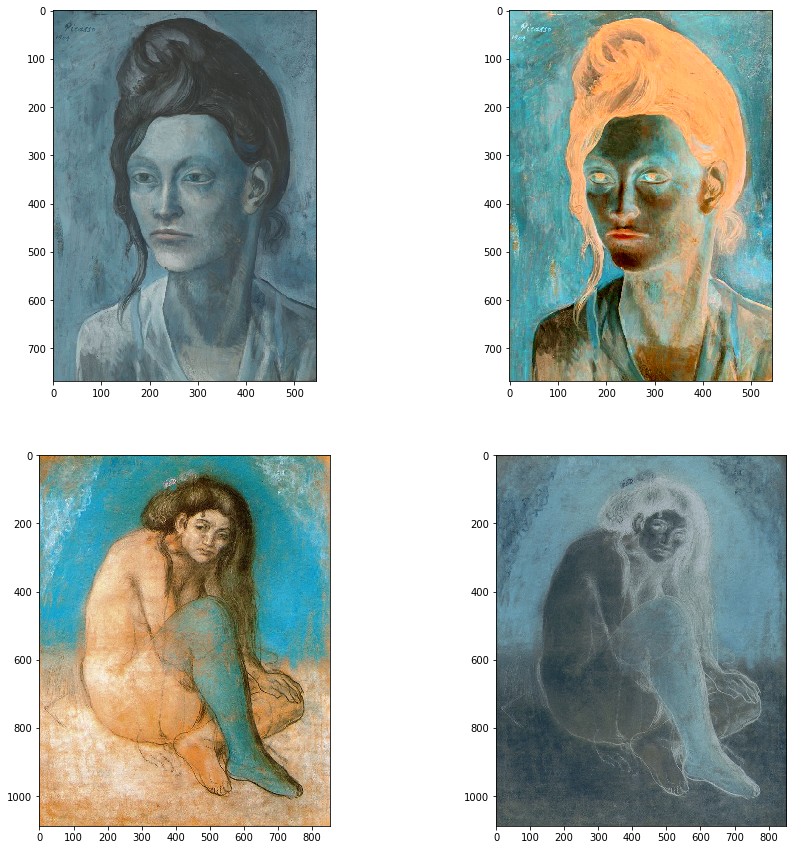

In [257]:
pca_blue = PCA(whiten=True)
pca_blue.fit(blue_cs)
xi_blue = pca_blue.transform(y_blue)

pca_pink = PCA(whiten=True)
pca_pink.fit(pink_cs)
xi_pink = pca_pink.transform(y_pink)

z_blue = DataFrame(np.clip(pca_pink.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])
z_pink = DataFrame(np.clip(pca_blue.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(z_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(z_pink, m_pink, n_pink))

# Homework

\item This exercise explores how principal component analysis can be used for dimensionality reduction.  Assume that the actual data $\vec{x}_1,\ldots,\vec{x}_m$ is located on the low-dimensional space or curve but our observations $\vec{y}_1,\ldots,\vec{y}_m$ are shifted due to white Gaussian noise.
\begin{enumerate}
\item Generate the data located on the straight line specified by parametrised equation
\begin{align*}
\begin{cases}
 x_1 &= t\enspace,\\
 x_2 &= 2t\enspace,\\
 x_3 &= 3 - t\enspace.
\end{cases}
\end{align*}
For instance sample $t$ value uniformly $500$ times from the range $[0,1]$ and add white Gaussian noise $\varepsilon_1,\varepsilon_2,\varepsilon_3\sim\NNN(0,0.1)$. Visualise the original data and disturbed data using \texttt{plot3d} and \texttt{rgl.points} form the \texttt{rgl} package. You can use functions \texttt{rgl.postscript} and \texttt{rgl.snapshot} to take snapshots of the \texttt{rgl} visualisation tool. (\textbf{0.5p})


\item Use the function \texttt{prcomp} to find the principal components of the data. Since the original data is one-dimensional, use the first coordinate of the PCA and the first principal component to reduce the data as a one-dimensional object. Compare the reconstructed line with the original line. Are they well aligned? Visualise also the distance between the original data points and reconstructed data points. Compare it with the distance between the original data points and observed data points. Use histograms for that. What is the main reason that the data is not completely reconstructed and how precise the reconstruction is on average? (\textbf{1p})     
\item Generate the data located on the plane  specified by parametrised equation
\begin{align*}
\vec{x}=t_1\vec{p}_1+t_2\vec{p}_2
\end{align*}
where $\vec{p}_1=(1,1,1)^T$ and $\vec{p}_2=(0,1,-1)^T$. Again, generate $500$ data points on the plain and add white Gaussian noise $\varepsilon_1,\varepsilon_2,\varepsilon_3\sim\NNN(0,0.1)$. Visualise the original data and disturbed data using \texttt{plot3d} and \texttt{rgl.points}. Reconstruct the plane using PCA. Again, estimate the reconstruction precision by comparing the distance distributions between original, reconstructed and observed data. (\textbf{1p})